# Culinary Constellations

In this notebook we will be analizing how different food venues are clustered together.  
The goal is to identify food venue concentrations and analyze it´s cluster composition.  

In order to archieve this, we first identify food venue clusters accross the country  
using DBSCAN algorithm. We will retrive the food venue listing from the Foursquare API, 
cluster it using scikit library, and select training clusters by diversity score and
cluster size.

The resulting clusters will be analyzed using Logistic Regression, again using scikit 
library. Analysis will be focused on cluster composition, as the cluster features will  
be the proportional share of a food category of a venue composing the whole of the  
venues in a food cluster.

In the end we will find out if there is pattern in the food cluster composition, and if
there is, how it looks like. Thi process is done following the steps outlined below:

- Environmet setup.
- Retrive city list with diversity score.
- Enrich city list with geospatial coordinates using **GeoPy**.
- Get food venue list in each city using **Foursquare API**.
- Group food venues into clusters each city using **DBSCAN**.
- Create cites interactive html files for resulting clusters  
  visualization using **Folium**.
- Merge clusters across all cities, apply the data  
  selection of choice and perform and explore resulting data
- Perform Data Preprocessing and Statistical Testing
- Train and Evaluate the **Logistic Regression** model

Evaluating the model and it's results will lead to the conclusions described in the report.


_______________________________________
## Environment setup

The following packages should be installed:

In [2]:
# Geolocalization API
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##########################

In [1]:
# Geolocation vizualization tool
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    attrs-20.3.0               |     pyhd3deb0d_0          41 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36he6145b8_1001         347 KB  conda-forge
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    certifi-2020.11.8          |   py36h5fab9bb

_________________________________
## Retrieve city list with diversity score

In [5]:
import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

We are going to explore several cities across the US in order to find food venues clusters.
The city list below was obtained from the following URL:

<a href="#City diversity score list">https://wallethub.com/edu/cities-with-the-most-and-least-ethno-racial-and-linguistic-diversity/10264</a>



In [6]:
# The most diverse (large) cities are shown in the listing below:
path = 'Large_Cities_Cultural_Diversity.csv'
large_city_list = pd.read_csv(path)
large_city_list.set_index('Overal Rank',drop=True,inplace=True)
large_city_list.head()

,City,Diversity Score
Overal Rank,,
1,"New York, NY",69.38
2,"Oakland, California",68.95
3,"San Jose, CA",68.56
4,"Sacramento, CA",66.33
5,"San Francisco, California",66.29


_______________________________________
## Enrich city list with geospatial coordinates

In [10]:
# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# library to handle requests
import requests 

In [11]:
# add empty columns to be updated by the actual city latitude and longitude
enriching_columns = ['Latitude','Longitude']
city_info = large_city_list.reindex(columns=[*large_city_list.columns.tolist(),*enriching_columns],fill_value=0.0).copy()
city_info.sample(3)

,City,Diversity Score,Latitude,Longitude
Overal Rank,,,,
26,"Bakersfield, CA",57.69,0.0,0.0
47,"Wichita, KS",47.42,0.0,0.0
20,"Fort Worth, TX",60.57,0.0,0.0


In [12]:
# GeoPy locator API
geolocator = Nominatim(user_agent="city_explorer")

# Iterate though each city and get geospatial coordinates
for index, row in large_city_list.iterrows():
    address = row['City']
    location = geolocator.geocode(address)
    print('The geograpical coordinate of {} are {}, {}.'
      .format(address, location.latitude, location.longitude))
    city_info.loc[index,'Latitude'] = location.latitude
    city_info.loc[index,'Longitude'] = location.longitude


The geograpical coordinate of New York, NY are 40.7127281, -74.0060152.
The geograpical coordinate of Oakland, California are 37.8044557, -122.2713563.
The geograpical coordinate of San Jose, CA are 37.3361905, -121.8905833.
The geograpical coordinate of Sacramento, CA are 38.5815719, -121.4943996.
The geograpical coordinate of San Francisco, California are 37.7790262, -122.4199061.
The geograpical coordinate of Boston, MA are 42.3602534, -71.0582912.
The geograpical coordinate of San Diego, CA are 32.7174209, -117.1627714.
The geograpical coordinate of Los Angeles, CA are 34.0536909, -118.2427666.
The geograpical coordinate of Long Beach, California are 33.7690164, -118.1916048.
The geograpical coordinate of Houston, TX are 29.7589382, -95.3676974.
The geograpical coordinate of Aurora, CO are 39.729432, -104.8319196.
The geograpical coordinate of Las Vegas, NV are 36.1672559, -115.1485163.
The geograpical coordinate of Arlington, TX are 32.701938999999996, -97.10562379033699.
The geog

In [13]:
city_info.head()

,City,Diversity Score,Latitude,Longitude
Overal Rank,,,,
1,"New York, NY",69.38,40.712728,-74.006015
2,"Oakland, California",68.95,37.804456,-122.271356
3,"San Jose, CA",68.56,37.336191,-121.890583
4,"Sacramento, CA",66.33,38.581572,-121.494400
5,"San Francisco, California",66.29,37.779026,-122.419906


In [14]:
# let's save our progress,
# the geospatial API is sometimes unstable, so is better to keep the data when available.
city_info.to_csv('city_info.csv')

__________________________________
## Get food venue list in each city using Foursquare API

In [17]:
# restore our work
path = 'city_info.csv'
city_info = pd.read_csv(path)
city_info.set_index('Overal Rank',drop=True,inplace=True)
city_info.head()

,City,Diversity Score,Latitude,Longitude
Overal Rank,,,,
1,"New York, NY",69.38,40.712728,-74.006015
2,"Oakland, California",68.95,37.804456,-122.271356
3,"San Jose, CA",68.56,37.336191,-121.890583
4,"Sacramento, CA",66.33,38.581572,-121.494400
5,"San Francisco, California",66.29,37.779026,-122.419906


In [18]:
# @hidden_cell

Foursquare Credentials and Version have been defined in secrecy


In [19]:
# library to handle requests
import requests 

In [20]:
#The id for 'food' category in Foursquare API is '4d4b7105d754a06374d81259'
category_id = '4d4b7105d754a06374d81259'

# initialize city venues list
city_venues_list = []

# iterate over each large city:
for index, row in city_info.iterrows():
    if row['Diversity Score'] >= 40:
        lat = row['Latitude']
        lng = row['Longitude']
        radius = 2000
        offset = 0
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}&offset={}'.format(
                    CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, category_id, LIMIT, offset)

        # make the GET request
        print("City:",row['City'])
        results = requests.get(url).json()["response"]
        #print("number of groups:",len(results['groups']))
        items = results['groups'][0]['items']
        #print("number of items:",len(items))
        totalResults = results['totalResults']
        print("Total Results:",totalResults)
        
        # in order to obtain paged result the endpoint must be called several times
        offset = 0
        venues_list = []
        while offset<totalResults:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}&offset={}'.format(
                    CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, category_id, LIMIT, offset)
            print(url)
            results = requests.get(url).json()["response"]
            items = results['groups'][0]['items']
            offset+=50
            venues_list.extend(
            [(row['City'],
              index,
              row['Diversity Score'],
            i['venue']['name'],
            i['venue']['location']['lat'], 
            i['venue']['location']['lng'],
            i['venue']['location']['distance'],
            i['venue']['categories'][0]['name'],
            i['venue']['id']) for i in items])

        #Create a pandas Dataframe from the venues list
        column_names = ['city','rank','score','name', 'latitude', 'longitude', 'downtown_dist', 'main_category','id']
        food_venues = pd.DataFrame(venues_list, columns = column_names) 
        #
        city_venues_list.append((index, row['City'],row['Diversity Score'],row['Latitude'],row['Longitude'],food_venues))

City: New York, NY
Total Results: 247
https://api.foursquare.com/v2/venues/explore?&client_id=5RVZ3HAKX3NZKEAZMXP5041EA5UI4VU4ZALBBV3SCXZ31YDS&client_secret=0QPPIKMPEY3XMQIX5JO5OQRBFXAYXHIRGAUHMGPGGE3NH1M2&v=20180604&ll=40.7127281,-74.0060152&radius=2000&categoryId=4d4b7105d754a06374d81259&limit=50&offset=0
https://api.foursquare.com/v2/venues/explore?&client_id=5RVZ3HAKX3NZKEAZMXP5041EA5UI4VU4ZALBBV3SCXZ31YDS&client_secret=0QPPIKMPEY3XMQIX5JO5OQRBFXAYXHIRGAUHMGPGGE3NH1M2&v=20180604&ll=40.7127281,-74.0060152&radius=2000&categoryId=4d4b7105d754a06374d81259&limit=50&offset=50
https://api.foursquare.com/v2/venues/explore?&client_id=5RVZ3HAKX3NZKEAZMXP5041EA5UI4VU4ZALBBV3SCXZ31YDS&client_secret=0QPPIKMPEY3XMQIX5JO5OQRBFXAYXHIRGAUHMGPGGE3NH1M2&v=20180604&ll=40.7127281,-74.0060152&radius=2000&categoryId=4d4b7105d754a06374d81259&limit=50&offset=100
https://api.foursquare.com/v2/venues/explore?&client_id=5RVZ3HAKX3NZKEAZMXP5041EA5UI4VU4ZALBBV3SCXZ31YDS&client_secret=0QPPIKMPEY3XMQIX5JO5OQRBFXA

__________________________
Let's do some data exploration on the dataset we have just obtained.  
Below is the count for the food venues found 2 kms around each city center:

In [34]:
# food venues found per city:
food_venues_per_city = pd.DataFrame([(x[1],len(x[5])) for x in city_venues_list],columns=['city name','food venues found'])
food_venues_per_city.set_index('city name',drop=True,inplace=True)
print("\nTotal food venues found:",food_venues_per_city.sum().values)
print("\nFood venue count per city average:",food_venues_per_city.mean().values)


Total food venues found: [8881]

Food venue count per city average: [148.01666667]


In [42]:
print("\nTop 5 cities by food venue count:")
food_venues_per_city.sort_values('food venues found',ascending=False).head()


Top 5 cities by food venue count:


,food venues found
city name,
"Baltimore, MD",249
"Honolulu, HI",249
"New York, NY",247
"Boston, MA",247
"Seattle, WA",247


________________
## Group food venues into clusters each city using DBSCAN

In [44]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [45]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# define epsilon as 200 feet or 61 meters 0.061 kilometers, converted to radians for use by haversine
epsilon = 0.061 / kms_per_radian

In [46]:
#initialize cluster list
city_clustered_culinary = []
global_num_clusters = 0

# itearate over the food venues obtained form Foursquare:
for x in city_venues_list:
    overal_rank = x[0]
    city = x[1]
    diversity_score = x[2]
    latitude = x[3]
    longitude = x[4]
    food_venues = x[5]

    iteration_txt = 'City: {}, Overal Rank: {}, Diversity Score: {}.'
    print(iteration_txt.format(city, overal_rank, diversity_score))
    
    # represent points consistently as (lat, lon)
    coords = food_venues[['latitude', 'longitude']].to_numpy()

    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    global_cluster_labels = [cluster_label + global_num_clusters for cluster_label in cluster_labels]

    # get the number of clusters
    num_clusters = len(set(cluster_labels))
    global_num_clusters += num_clusters

    # all done, print the outcome
    message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression'
    print(message.format(len(food_venues), num_clusters, 100*(1 - float(num_clusters) / len(food_venues))))
    print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

    # add clustering labels column
    clustered_culinary = food_venues.copy()
    clustered_culinary.insert(0, 'global label', global_cluster_labels)
    clustered_culinary.insert(0, 'cluster labels', cluster_labels)
    
    # add to city list with clustered venues
    city_clustered_culinary.append((overal_rank,city,diversity_score,latitude,longitude,
                                    num_clusters,clustered_culinary))

City: New York, NY, Overal Rank: 1, Diversity Score: 69.38.
Clustered 247 points down to 134 clusters, for 45.7% compression
Silhouette coefficient: 0.288
City: Oakland, California, Overal Rank: 2, Diversity Score: 68.95.
Clustered 179 points down to 109 clusters, for 39.1% compression
Silhouette coefficient: 0.330
City: San Jose, CA, Overal Rank: 3, Diversity Score: 68.56.
Clustered 162 points down to 90 clusters, for 44.4% compression
Silhouette coefficient: 0.450
City: Sacramento, CA, Overal Rank: 4, Diversity Score: 66.33.
Clustered 154 points down to 90 clusters, for 41.6% compression
Silhouette coefficient: 0.336
City: San Francisco, California, Overal Rank: 5, Diversity Score: 66.29.
Clustered 244 points down to 136 clusters, for 44.3% compression
Silhouette coefficient: 0.390
City: Boston, MA, Overal Rank: 6, Diversity Score: 65.81.
Clustered 247 points down to 135 clusters, for 45.3% compression
Silhouette coefficient: 0.288
City: San Diego, CA, Overal Rank: 7, Diversity Score

____________________
Let's look at the clusters we've just calculated  
Below are the clusters calculated for each city center:

In [68]:
clusters_per_city = pd.DataFrame( 
[(x[1],len(x[6]),x[5],
  x[6].groupby('global label').count()['cluster labels'].min(),
  x[6].groupby('global label').count()['cluster labels'].max(),
  x[6].groupby('global label').count()['cluster labels'].mean()) 
 for x in city_clustered_culinary],
 columns = ['city name','total venues','total clusters','min cluster size','max cluster size','mean cluster size'])

clusters_per_city.set_index('city name',drop=True,inplace=True)

print("\nTotal generated clusters:",clusters_per_city['total clusters'].sum())
print("\nMax cluster size:",clusters_per_city['max cluster size'].max())


Total generated clusters: 5039

Max cluster size: 30


In [65]:
print("\nTop 5 cities by max cluster size:")
clusters_per_city.sort_values('max cluster size',ascending=False).head()


Top 5 cities by max cluster size:


,total venues,total clusters,min cluster size,max cluster size,mean cluster size
city name,,,,,
"Boston, MA",247,135,1,30,1.829630
"Baltimore, MD",249,125,1,27,1.992000
"Columbus, OH",150,78,1,26,1.923077
"Seattle, WA",247,128,1,25,1.929688
"Atlanta, GA",168,81,1,23,2.074074


In [69]:
print("\nTop 5 cities by total clusters:")
clusters_per_city.sort_values('total clusters',ascending=False).head()


Top 5 cities by total clusters:


,total venues,total clusters,min cluster size,max cluster size,mean cluster size
city name,,,,,
"Portland, OR",233,147,1,13,1.585034
"Chicago, IL",245,142,1,16,1.725352
"San Francisco, California",244,136,1,13,1.794118
"Boston, MA",247,135,1,30,1.829630
"Philadelphia, PA",243,135,1,13,1.800000


In [121]:
print("\nTop 5 cities by mean cluster size:")
clusters_per_city.sort_values('mean cluster size',ascending=False).head()


Top 5 cities by mean cluster size:


,total venues,total clusters,min cluster size,max cluster size,mean cluster size
city name,,,,,
"Pittsburgh, PA",192,83,1,21,2.313253
"Honolulu, HI",249,115,1,20,2.165217
"Dallas, TX",221,103,1,13,2.145631
"Atlanta, GA",168,81,1,23,2.074074
"Las Vegas, NV",130,64,1,12,2.031250


In [122]:
print("\nBottom 5 cities by mean cluster size:")
clusters_per_city.sort_values('mean cluster size',ascending=False).tail()


Bottom 5 cities by mean cluster size:


,total venues,total clusters,min cluster size,max cluster size,mean cluster size
city name,,,,,
"Jacksonville, FL",68,51,1,5,1.333333
"Corpus Christi, TX",58,44,1,4,1.318182
"Oklahoma City, OK",78,60,1,5,1.300000
"Mesa, AZ",46,39,1,4,1.179487
"El Paso, TX",47,40,1,3,1.175000


______________________________________________________
## Create cites interactive html files for resulting clusters visualization

Visualy reviewing each city clusters in a map not only provide natural feedback on clusters  
shape and distribution, but also helps correct GeoPy address resolution when necesary.  
  
It can be observed in the underling map many food venues are not being returned by the  
Foursquare API. Remember that the explore endpoint only returns the "recommended" nearby venues.  
  
So, as pointed out when choosing the cluster distance between each sample, unless two  
recommended venues are next to each other, we can only be able to generate large clusters  
of food venues like gastromic boulevards, restaurant zones and other recreational areas.  

This can be visualized in the following interactive html files generated by the following.  
code. The script output throws the name of the html file of the corresponding city.

In [71]:
 # map rendering library
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [72]:
map_list = []

for x in city_clustered_culinary:
    # set parameters for current map
    overal_rank = x[0]
    city = x[1]
    diversity_score = x[2]
    latitude = x[3]
    longitude = x[4]
    num_clusters = x[5]
    clustered_culinary = x[6]

    iteration_txt = 'City: {}, Overal Rank: {}, Diversity Score: {}, Clusters: {}, Food venues: {}.'
    print(iteration_txt.format(city, overal_rank, diversity_score,num_clusters,len(clustered_culinary)))

    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

    # set color scheme for the clusters
    x = np.arange(num_clusters)
    ys = [i + x + (i*x)**2 for i in range(num_clusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(clustered_culinary['latitude'], clustered_culinary['longitude'], clustered_culinary['name'], clustered_culinary['cluster labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)

        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    map_clusters.save(city + '.html')
    print("      saved to:",city + '.html')
    map_list.append(map_clusters)

City: New York, NY, Overal Rank: 1, Diversity Score: 69.38, Clusters: 134, Food venues: 247.
      saved to: New York, NY.html
City: Oakland, California, Overal Rank: 2, Diversity Score: 68.95, Clusters: 109, Food venues: 179.
      saved to: Oakland, California.html
City: San Jose, CA, Overal Rank: 3, Diversity Score: 68.56, Clusters: 90, Food venues: 162.
      saved to: San Jose, CA.html
City: Sacramento, CA, Overal Rank: 4, Diversity Score: 66.33, Clusters: 90, Food venues: 154.
      saved to: Sacramento, CA.html
City: San Francisco, California, Overal Rank: 5, Diversity Score: 66.29, Clusters: 136, Food venues: 244.
      saved to: San Francisco, California.html
City: Boston, MA, Overal Rank: 6, Diversity Score: 65.81, Clusters: 135, Food venues: 247.
      saved to: Boston, MA.html
City: San Diego, CA, Overal Rank: 7, Diversity Score: 65.7, Clusters: 111, Food venues: 204.
      saved to: San Diego, CA.html
City: Los Angeles, CA, Overal Rank: 8, Diversity Score: 65.17, Clusters:

______________________________
Let's look at some interesting maps we have just generated:

In [119]:
# create series for name comparison:
city_name = [(x[1]) for x in city_clustered_culinary]

In [118]:
# The city with the largest cluster size
map_list[city_name.index('Boston, MA')]

In [139]:
# Many food venues, not so large clusters
map_list[city_name.index('Dallas, TX')]

_______________________________________________________
## Merge clusters across all cities in a single dataset

In [125]:
# all food venues in a single DataFrame
all_food_venues = pd.concat([x[6] for x in city_clustered_culinary])
all_food_venues.set_index('id',drop=True,inplace=True)
print("Dataset shape: ",all_food_venues.shape)
all_food_venues.head()

Dataset shape:  (8881, 10)


,cluster labels,global label,city,rank,score,name,latitude,longitude,downtown_dist,main_category
id,,,,,,,,,,
5d5f24ec09484500079aee00,0,0,"New York, NY",1,69.38,Los Tacos No. 1,40.714267,-74.008756,287,Taco Place
4c154c9a77cea593c401d260,1,1,"New York, NY",1,69.38,Takahachi Bakery,40.713653,-74.008804,256,Bakery
528bf16711d2b7722da6b51c,2,2,"New York, NY",1,69.38,Pisillo Italian Panini,40.710530,-74.007526,275,Sandwich Place
5c6f03f30802d4002c16884c,2,2,"New York, NY",1,69.38,Joe’s Pizza,40.710178,-74.007769,320,Pizza Place
50ba9119e4b071a4bae6dc10,3,3,"New York, NY",1,69.38,Nish Nūsh,40.715537,-74.007725,344,Falafel Restaurant


In [126]:
# save our progress so far
all_food_venues.to_csv('culinary_constellations.csv')

___________________________________________
## Apply data selection criteria and perform and explore resulting data

In [53]:
import pandas as pd # library for data analsysis
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [54]:
all_food_venues = pd.read_csv('culinary_constellations.csv')
all_food_venues.set_index('id',drop=True,inplace=True)

In [55]:
# Take a look at the full venue data set
all_food_venues.head()

,cluster labels,global label,city,rank,score,name,latitude,longitude,downtown_dist,main_category
id,,,,,,,,,,
5d5f24ec09484500079aee00,0,0,"New York, NY",1,69.38,Los Tacos No. 1,40.714267,-74.008756,287,Taco Place
4c154c9a77cea593c401d260,1,1,"New York, NY",1,69.38,Takahachi Bakery,40.713653,-74.008804,256,Bakery
528bf16711d2b7722da6b51c,2,2,"New York, NY",1,69.38,Pisillo Italian Panini,40.710530,-74.007526,275,Sandwich Place
5c6f03f30802d4002c16884c,2,2,"New York, NY",1,69.38,Joe’s Pizza,40.710178,-74.007769,320,Pizza Place
50ba9119e4b071a4bae6dc10,3,3,"New York, NY",1,69.38,Nish Nūsh,40.715537,-74.007725,344,Falafel Restaurant


In [56]:
# Group all cities clusters into a singe Cluster dataset
all_clusters = all_food_venues.groupby(['global label','city','rank','score'],dropna=False).count()[['name']]
all_clusters.rename(columns={'name':'venue_count'}, inplace=True)
all_clusters.reset_index(['city','rank','score'], inplace=True)

In [57]:
# Take a look at all clusters data set
all_clusters.sort_values('venue_count',ascending = False).head()

,city,rank,score,venue_count
global label,,,,
567,"Boston, MA",6,65.81,30
4584,"Baltimore, MD",55,41.61,27
3607,"Columbus, OH",43,48.39,26
3105,"Seattle, WA",36,52.50,25
4594,"Baltimore, MD",55,41.61,24


The criteria for our cluster data set is as follows:  

- A cluster should be as big as 5 food venues in order to be considered as a cluster.  
- A cluster should belong to a city with diversity score above 50 to be considered having little cultural bias.

Visualize the cluster distribution by cluster size:

Text(0.5, 0, 'Cluster size (Number of food venues)')

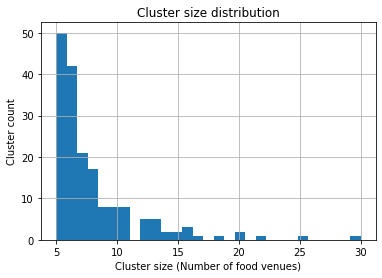

In [58]:
# Show cluster size histogram with the projected dataset
all_clusters['venue_count'][(all_clusters['score']>50) & (all_clusters['venue_count']>=5)].hist(bins=29)
plt.title('Cluster size distribution')
plt.ylabel('Cluster count')
plt.xlabel('Cluster size (Number of food venues)')

In [59]:
# Create the final Culinary Constellations cluster dataset by appling the given citeria
# - Diversity score above 50
# - Cluster size 5 and above
culinary_constellations = all_clusters[(all_clusters['score']>50) & (all_clusters['venue_count']>4)]
cc = culinary_constellations

In [60]:
culinary_constellations.sort_values('venue_count',ascending = False)

,city,rank,score,venue_count
global label,,,,
567,"Boston, MA",6,65.81,30
3105,"Seattle, WA",36,52.50,25
708,"San Diego, CA",7,65.70,22
342,"Sacramento, CA",4,66.33,20
1927,"Honolulu, HI",22,59.63,20
...,...,...,...,...
1832,"St. Paul, MN",21,59.65,5
1821,"St. Paul, MN",21,59.65,5
1752,"Fort Worth, TX",20,60.57,5


In [61]:
# Create the final Culinary Stars venue dataset by selecting only those venues
# that belong to our Culinary Constellation dataset.
culinary_stars = all_food_venues[['global label','cluster labels','name','latitude','longitude','main_category']]\
    .join(culinary_constellations,on='global label',how='inner')
culinary_stars

,global label,cluster labels,name,latitude,longitude,main_category,city,rank,score,venue_count
id,,,,,,,,,,
5521c2ff498ebe2368634187,48,48,Kiki's,40.714476,-73.992036,Greek Restaurant,"New York, NY",1,69.38,5
4fd38a04e4b065401a9aaf88,48,48,Forgtmenot,40.714459,-73.991546,New American Restaurant,"New York, NY",1,69.38,5
5cd1aa6a9d746800394f556d,48,48,Michaeli Bakery,40.714704,-73.991847,Bakery,"New York, NY",1,69.38,5
4b89ac72f964a520e94a32e3,48,48,Ling Kee Malaysian Beef Jerky,40.714713,-73.991538,Asian Restaurant,"New York, NY",1,69.38,5
59480a78f62e090a3b4d6eb7,48,48,Cervo's,40.714763,-73.991455,Spanish Restaurant,"New York, NY",1,69.38,5
...,...,...,...,...,...,...,...,...,...,...
56a67c7b498edbdc64c266fb,3402,16,Burrito Gallery Brooklyn,30.323653,-81.670733,Burrito Place,"Jacksonville, FL",39,51.95,5
55f6ddd0498eb5f6b791161a,3402,16,Zoës Kitchen,30.323697,-81.670865,Mediterranean Restaurant,"Jacksonville, FL",39,51.95,5
55d5df7f498edddede8311c5,3402,16,BurgerFi,30.323595,-81.671219,Burger Joint,"Jacksonville, FL",39,51.95,5


In [62]:
print("total venues in dataset:",culinary_stars.shape[0])
print("total clusters in dataset:",culinary_constellations.shape[0])
print("cluster min size:",culinary_constellations['venue_count'].min())
print("cluster max size:",culinary_constellations['venue_count'].max())
print("cluster mean size:",culinary_constellations['venue_count'].mean())
#culinary_stars

total venues in dataset: 1408
total clusters in dataset: 178
cluster min size: 5
cluster max size: 30
cluster mean size: 7.910112359550562


## Perform Data Preprocessing

In [63]:
# export food venue to group categorys off line:
categories = pd.DataFrame(culinary_stars.value_counts('main_category'),columns=['count'])
categories.to_csv('food_venue_categories.csv')

In [64]:
# display final food category mapping
grouped_categories = pd.read_csv('food_grouped_categories.csv')
grouped_categories.set_index('main_category',drop=True,inplace=True)
grouped_categories.drop(columns=['count'],inplace=True)
grouped_categories.head(15)

,food_category
main_category,
Mexican Restaurant,Mexican Restaurant
Pizza Place,Pizza Place
Italian Restaurant,Italian Restaurant
American Restaurant,American Restaurant
Sandwich Place,Sandwich Place
Seafood Restaurant,Seafood Restaurant
Sushi Restaurant,Japanese Restaurant
Japanese Restaurant,Japanese Restaurant
Bakery,Cafe & Bistro


In [65]:
# apply grouped food clasification to food venues
culinary_stars = culinary_stars.join(grouped_categories,on='main_category')
culinary_stars

,global label,cluster labels,name,latitude,longitude,main_category,city,rank,score,venue_count,food_category
id,,,,,,,,,,,
5521c2ff498ebe2368634187,48,48,Kiki's,40.714476,-73.992036,Greek Restaurant,"New York, NY",1,69.38,5,Mediterranean Restaurant
4fd38a04e4b065401a9aaf88,48,48,Forgtmenot,40.714459,-73.991546,New American Restaurant,"New York, NY",1,69.38,5,American Restaurant
5cd1aa6a9d746800394f556d,48,48,Michaeli Bakery,40.714704,-73.991847,Bakery,"New York, NY",1,69.38,5,Cafe & Bistro
4b89ac72f964a520e94a32e3,48,48,Ling Kee Malaysian Beef Jerky,40.714713,-73.991538,Asian Restaurant,"New York, NY",1,69.38,5,Asian Restaurant
59480a78f62e090a3b4d6eb7,48,48,Cervo's,40.714763,-73.991455,Spanish Restaurant,"New York, NY",1,69.38,5,Latin American Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
56a67c7b498edbdc64c266fb,3402,16,Burrito Gallery Brooklyn,30.323653,-81.670733,Burrito Place,"Jacksonville, FL",39,51.95,5,Mexican Restaurant
55f6ddd0498eb5f6b791161a,3402,16,Zoës Kitchen,30.323697,-81.670865,Mediterranean Restaurant,"Jacksonville, FL",39,51.95,5,Mediterranean Restaurant
55d5df7f498edddede8311c5,3402,16,BurgerFi,30.323595,-81.671219,Burger Joint,"Jacksonville, FL",39,51.95,5,Burger Joint


In [66]:
#culinary stars features
cs_features = pd.get_dummies(culinary_stars[['food_category']], prefix='', prefix_sep='')
culinary_stars = culinary_stars.join(cs_features)
culinary_stars

,global label,cluster labels,name,latitude,longitude,main_category,city,rank,score,venue_count,...,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Steakhouse
id,,,,,,,,,,,,,,,,,,,,,
5521c2ff498ebe2368634187,48,48,Kiki's,40.714476,-73.992036,Greek Restaurant,"New York, NY",1,69.38,5,...,0,0,1,0,0,0,0,0,0,0
4fd38a04e4b065401a9aaf88,48,48,Forgtmenot,40.714459,-73.991546,New American Restaurant,"New York, NY",1,69.38,5,...,0,0,0,0,0,0,0,0,0,0
5cd1aa6a9d746800394f556d,48,48,Michaeli Bakery,40.714704,-73.991847,Bakery,"New York, NY",1,69.38,5,...,0,0,0,0,0,0,0,0,0,0
4b89ac72f964a520e94a32e3,48,48,Ling Kee Malaysian Beef Jerky,40.714713,-73.991538,Asian Restaurant,"New York, NY",1,69.38,5,...,0,0,0,0,0,0,0,0,0,0
59480a78f62e090a3b4d6eb7,48,48,Cervo's,40.714763,-73.991455,Spanish Restaurant,"New York, NY",1,69.38,5,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56a67c7b498edbdc64c266fb,3402,16,Burrito Gallery Brooklyn,30.323653,-81.670733,Burrito Place,"Jacksonville, FL",39,51.95,5,...,0,0,0,1,0,0,0,0,0,0
55f6ddd0498eb5f6b791161a,3402,16,Zoës Kitchen,30.323697,-81.670865,Mediterranean Restaurant,"Jacksonville, FL",39,51.95,5,...,0,0,1,0,0,0,0,0,0,0
55d5df7f498edddede8311c5,3402,16,BurgerFi,30.323595,-81.671219,Burger Joint,"Jacksonville, FL",39,51.95,5,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# list of venue categories
features_columns = culinary_stars['food_category'].unique().tolist()
features_columns

['Mediterranean Restaurant',
 'American Restaurant',
 'Cafe & Bistro',
 'Asian Restaurant',
 'Latin American Restaurant',
 'Salad Place',
 'Pizza Place',
 'Mexican Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Sandwich Place',
 'Snack Place',
 'European Restaurant',
 'Comfort Food Restaurant',
 'Steakhouse',
 'Seafood Restaurant',
 'Fast Food Restaurant',
 'Burger Joint']

In [68]:
#culinary constellations features
venues_summary = culinary_stars.groupby('global label').sum()[features_columns]
cc_features = venues_summary.div(venues_summary.sum(1),0)
cc_features

,Mediterranean Restaurant,American Restaurant,Cafe & Bistro,Asian Restaurant,Latin American Restaurant,Salad Place,Pizza Place,Mexican Restaurant,Italian Restaurant,Japanese Restaurant,Sandwich Place,Snack Place,European Restaurant,Comfort Food Restaurant,Steakhouse,Seafood Restaurant,Fast Food Restaurant,Burger Joint
global label,,,,,,,,,,,,,,,,,,
48,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000
50,0.285714,0.000000,0.000000,0.000000,0.000000,0.142857,0.285714,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000
62,0.166667,0.000000,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000
65,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.333333,0.166667,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000
76,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.142857,0.000000,0.142857,0.285714,0.000000,0.000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.000,0.0,0.166667,0.000000
3328,0.000000,0.222222,0.000000,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.222222,0.000,0.0,0.000000,0.111111
3341,0.125000,0.000000,0.000000,0.250000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.125000,0.000000,0.000000,0.125,0.0,0.000000,0.000000


## Inferential statistical testing

We will generate a correlation matrix and visualize it, in order to  
examine potential correlation the cluster composition

In [69]:
#show the correlation matrix
cc_features.corr()

,Mediterranean Restaurant,American Restaurant,Cafe & Bistro,Asian Restaurant,Latin American Restaurant,Salad Place,Pizza Place,Mexican Restaurant,Italian Restaurant,Japanese Restaurant,Sandwich Place,Snack Place,European Restaurant,Comfort Food Restaurant,Steakhouse,Seafood Restaurant,Fast Food Restaurant,Burger Joint
Mediterranean Restaurant,1.000000,-0.100630,-0.117413,-0.144372,0.014968,-0.064653,0.088443,0.006334,-0.064218,-0.041929,0.086915,-0.019084,-0.056319,-0.048298,-0.001446,-0.060656,-0.125347,-0.019779
American Restaurant,-0.100630,1.000000,-0.040371,-0.215129,-0.042705,-0.059624,-0.145048,0.006663,-0.054627,-0.134604,-0.192205,-0.084984,-0.037367,-0.114808,-0.006851,0.033293,-0.147359,0.057505
Cafe & Bistro,-0.117413,-0.040371,1.000000,-0.005590,-0.122819,0.074759,-0.042023,-0.065382,0.077601,-0.081365,-0.213537,-0.115142,-0.080169,-0.041156,0.001320,-0.147063,-0.072120,-0.129339
Asian Restaurant,-0.144372,-0.215129,-0.005590,1.000000,-0.113150,-0.105678,-0.175940,-0.163667,-0.190972,0.044247,-0.130893,-0.066335,-0.119716,-0.086947,-0.151387,-0.081517,-0.078348,-0.139591
Latin American Restaurant,0.014968,-0.042705,-0.122819,-0.113150,1.000000,-0.008754,-0.077534,-0.085165,0.004283,-0.052175,0.027879,-0.108216,0.038402,0.118503,0.052014,-0.034049,-0.049090,-0.023425
Salad Place,-0.064653,-0.059624,0.074759,-0.105678,-0.008754,1.000000,-0.036593,-0.064691,-0.072066,-0.089831,0.070223,0.000770,-0.120251,0.050802,0.089135,-0.143985,-0.063698,-0.027213
Pizza Place,0.088443,-0.145048,-0.042023,-0.175940,-0.077534,-0.036593,1.000000,0.010521,-0.026857,-0.052512,0.041685,-0.043045,0.025264,-0.094669,-0.157998,-0.036124,-0.022152,-0.098664
Mexican Restaurant,0.006334,0.006663,-0.065382,-0.163667,-0.085165,-0.064691,0.010521,1.000000,-0.113217,-0.123102,-0.082758,-0.026817,-0.155982,-0.095807,-0.106424,-0.085413,-0.049600,0.062435
Italian Restaurant,-0.064218,-0.054627,0.077601,-0.190972,0.004283,-0.072066,-0.026857,-0.113217,1.000000,-0.079724,-0.122829,0.027188,0.085120,-0.042700,-0.048585,0.016062,-0.183661,-0.005119
Japanese Restaurant,-0.041929,-0.134604,-0.081365,0.044247,-0.052175,-0.089831,-0.052512,-0.123102,-0.079724,1.000000,-0.135727,-0.037715,-0.103014,-0.063811,-0.109222,-0.122220,-0.121012,-0.146919


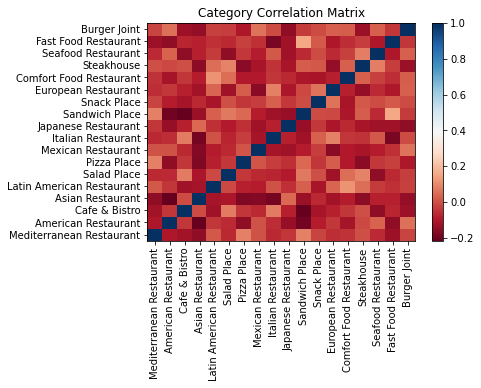

In [70]:
#display correlation matrix heatmap
grouped_pivot=cc_features.corr()

fig, ax = plt.subplots()
im = ax.pcolor(grouped_pivot, cmap='RdBu')

#label names
row_labels = grouped_pivot.columns #.levels[1]
col_labels = grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.title('Category Correlation Matrix')
plt.show()

The correlation matrix show none or very little correlation between a food category and another.
More detailed analysis in the report.

## Train and Evaluate Logistic Regression model

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# function used to create confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Analyze for a sandwich place

In [73]:
# Generate the samples for our model in numpy

# Let's train the model for a probabiliy of the cluster to contain a sandwich place
target_category = 'Sandwich Place'
feature_categories = cc_features.columns.to_list()
feature_categories.remove(target_category)

X = cc_features[feature_categories].to_numpy()
y = cc_features[target_category].map(lambda x: 1 if x>0 else 0 ).to_numpy()

print("\n Dataset (numpy):",X)
print("\n Resultset (numpy):",y)


 Dataset (numpy): [[0.2        0.2        0.2        ... 0.         0.         0.        ]
 [0.28571429 0.         0.         ... 0.         0.         0.        ]
 [0.16666667 0.         0.16666667 ... 0.         0.         0.        ]
 ...
 [0.125      0.         0.         ... 0.         0.         0.        ]
 [0.         0.16666667 0.16666667 ... 0.         0.33333333 0.        ]
 [0.2        0.         0.         ... 0.         0.         0.2       ]]

 Resultset (numpy): [0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1
 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1
 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0]


In [74]:
# Create the train and the test datasets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (142, 17) (142,)
Test set: (36, 17) (36,)


In [75]:
# Train the Logistic Regression Model
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [76]:
# Show the order of the output classes (first column for 0 and second column for 1)
LR.classes_

array([0, 1])

In [85]:
# Show the outcome of the model for the test dataset
yhat_prob = LR.predict_proba(X_test)
yhat_prob_df = pd.DataFrame(yhat_prob,columns=['without sandwich place','with sandwich place'])
yhat_prob_df.index.rename('test cluster index',inplace=True)
yhat_prob_df

,without sandwich place,with sandwich place
test cluster index,,
0,0.529846,0.470154
1,0.532631,0.467369
2,0.529450,0.470550
3,0.531106,0.468894
4,0.531077,0.468923
5,0.531318,0.468682
6,0.527761,0.472239
7,0.527849,0.472151
8,0.527534,0.472466


There is a very small variation in the probability to find a sandwich venue from cluster to cluster.  
The probability varies between 46% and 47%

In [87]:
# show jaccard similarity score 
jaccard_similarity_score(y_test, LR.predict(X_test))

0.7777777777777778

A surpisingly high score given the small variations in probability

Confusion matrix, without normalization
[[ 0  8]
 [ 0 28]]


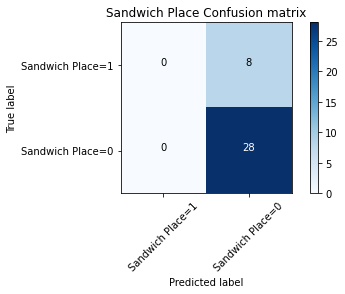

In [88]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, LR.predict(X_test), labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[target_category+'=1',target_category+'=0'],normalize= False,
                      title= target_category + ' Confusion matrix')

In [109]:
# Get model coefficients to show the impact of each category
RL_coefficients = pd.DataFrame(LR.coef_,columns = feature_categories)
RL_coefficients.index.rename('RL coefficients',inplace = True)
RL_coefficients = RL_coefficients.T #.columns=['value']
RL_coefficients.columns=['coefficients_value']
RL_coefficients.sort_values('coefficients_value',ascending=False)

,value
Pizza Place,0.002769
Salad Place,0.000942
Snack Place,0.000525
Mediterranean Restaurant,0.000246
Fast Food Restaurant,-0.000465
Latin American Restaurant,-0.000919
Steakhouse,-0.003952
Seafood Restaurant,-0.004336
European Restaurant,-0.004571
Burger Joint,-0.008050


The location of a sandwich place is largely independent of other venues, but there is very small probability to find a sandwich plase next to a Pizza Place, than next to an Asian Restaurant

### Repeat the analysis for an Asian Restaurant

In [110]:
target_category = 'Asian Restaurant'
feature_categories = cc_features.columns.to_list()
feature_categories.remove(target_category)

X = cc_features[feature_categories].to_numpy()
y = cc_features[target_category].map(lambda x: 1 if x>0 else 0 ).to_numpy()
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [116]:
# Show the order of the output classes (first column for 0 and second column for 1)
LR.classes_

array([0, 1])

In [119]:
# Show the outcome of the model for the test dataset
yhat_prob = LR.predict_proba(X_test)
yhat_prob_df = pd.DataFrame(yhat_prob,columns=['without asian restaurant','with asian restaurant'])
yhat_prob_df.index.rename('test cluster index',inplace=True)
yhat_prob_df.sample(5)

,without asian restaurant,with asian restaurant
test cluster index,,
28,0.476036,0.523964
20,0.475679,0.524321
32,0.475923,0.524077
22,0.477211,0.522789
27,0.476500,0.523500


The probability of finding an asian restaurant is a solid 52% no matter the cluster

Jacard Similarity Score: 0.5 

Confusion matrix, without normalization
[[18  0]
 [18  0]]


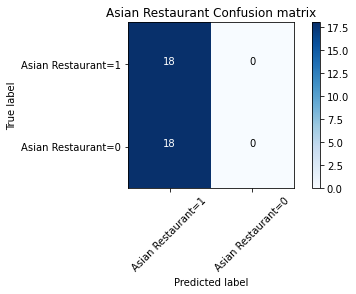

In [120]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

print("Jacard Similarity Score:",jaccard_similarity_score(y_test, LR.predict(X_test)),"\n")

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, LR.predict(X_test), labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[target_category+'=1',target_category+'=0'],normalize= False,
                      title= target_category + ' Confusion matrix')

asian restaurants don't care about the cluster composition

In [121]:
len(LR.coef_.tolist()[0])

17

In [122]:
LR.coef_

array([[-0.  , -0.01,  0.01,  0.  ,  0.  , -0.  ,  0.  , -0.01,  0.01,
         0.  , -0.  , -0.  , -0.  ,  0.  , -0.  , -0.  , -0.  ]])

In [123]:
# Get model coefficients to show the impact of each category
RL_coefficients = pd.DataFrame(LR.coef_,columns = feature_categories)
RL_coefficients.index.rename('RL coefficients',inplace = True)
RL_coefficients = RL_coefficients.T #.columns=['value']
RL_coefficients.columns=['coefficients_value']
RL_coefficients.sort_values('coefficients_value',ascending=False)

,coefficients_value
Japanese Restaurant,0.011503
Cafe & Bistro,0.010085
Latin American Restaurant,0.004039
Salad Place,0.003518
Steakhouse,0.002540
Mexican Restaurant,0.001503
Sandwich Place,0.000889
Comfort Food Restaurant,-0.001014
Snack Place,-0.001090
Fast Food Restaurant,-0.001098


In [124]:
# The 0.5 Jackard score is one the most relevant data the asian restaurant analysis
print("Jacard Similarity Score:",jaccard_similarity_score(y_test, LR.predict(X_test)),"\n")

Jacard Similarity Score: 0.5 



When evaluating the asian restaurant with test data, unlike the sandwich place, no correlation was found between the cluster composition and the probability to find an asian restaurant in a food cluster.

But looking at the sightly above 50% probability of finding an asian restaurant than not, is seems placing an asian restaurant is a bit safer bet regardless of the cluster composition.